In [1]:
import torch

In [2]:
from torch.utils.data import Dataset, DataLoader


def generateGaussian(tindx):
    return torch.normal(tindx[0], tindx[1], (1, 42, 42))

class MyDataset(Dataset):
    def __init__(self, n):
        classes = {0:(0.5, 2), 1:(1, 2.5)}
        self.y = [torch.round(torch.rand(1))[0].long() for i in range(n)]
        self.X = [generateGaussian(classes[self.y[i].item()]) for i in range(n)]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [3]:
import torch
import torch.nn as nn
from torch import optim

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(1, 16, kernel_size = 3, stride = 2, padding=2), 
        nn.ReLU(), 
        nn.MaxPool2d((2, 2), stride = 2), 
        nn.Conv2d(16, 32, kernel_size = 3, stride =1, padding = 0), 
        nn.ReLU(), 
        nn.MaxPool2d((2, 2), stride = 2), 
        nn.Conv2d(32, 4, kernel_size = 3, stride = 2, padding = 2), 
        nn.ReLU(), 
        nn.MaxPool2d((2, 2), stride = 2))
        self.classification_head = nn.Sequential(nn.Linear(4, 20, bias = True),
        nn.ReLU(), 
        nn.Linear(20, 2, bias = True))

    def forward(self, x, batch_size):
        features = self.net(x)
        return self.classification_head(features.view(batch_size, -1))

class customdataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.y = self.y.type(torch.LongTensor)

    def size(self):
        return len(self.x)

    def get_item(self, index):
        return [self.x[index], self.y[index]]

In [4]:
data = MyDataset(1000)

stacked_0 = torch.stack(data.X, dim= 0)
stacked_1 = torch.stack(data.y, dim= 0)
d1 = customdataset(stacked_0, stacked_1)

In [39]:
m1 = CNN()
loss_fn = nn.CrossEntropyLoss()
batch_size = 4
train_data_loader = DataLoader(list(zip(d1.x, d1.y)), batch_size, shuffle = True)
optimizer = optim.SGD(m1.parameters(), lr=0.01)
losses = []

for epoch in range(5):
    m1.train(True)
    loss_t = 0
    for i, data in enumerate(train_data_loader):
        inputs, labels = data
        inputs = inputs.squeeze(1)
        inputs = torch.unsqueeze(inputs, 1)
        optimizer.zero_grad()
        outputs = m1.forward(inputs, batch_size)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if i%50 == 0:
            print("Data entry: " + str(i) + " Loss is " + str(loss.item()))
    loss_t = loss_t/(len(train_data_loader)*batch_size)
    losses.append(loss_t)
        

Data entry: 0 Loss is 0.7441999912261963
Data entry: 50 Loss is 0.7038244009017944
Data entry: 100 Loss is 0.6509103178977966
Data entry: 150 Loss is 0.5866546630859375
Data entry: 200 Loss is 0.679428219795227
Data entry: 0 Loss is 0.7268218398094177
Data entry: 50 Loss is 0.34086114168167114
Data entry: 100 Loss is 0.20164021849632263
Data entry: 150 Loss is 0.24524739384651184
Data entry: 200 Loss is 0.3322913944721222
Data entry: 0 Loss is 0.19170759618282318
Data entry: 50 Loss is 0.10180078446865082
Data entry: 100 Loss is 0.031914353370666504
Data entry: 150 Loss is 0.08290920406579971
Data entry: 200 Loss is 0.022728607058525085
Data entry: 0 Loss is 0.030366279184818268
Data entry: 50 Loss is 0.030413197353482246
Data entry: 100 Loss is 0.00713980570435524
Data entry: 150 Loss is 0.02408703602850437
Data entry: 200 Loss is 0.003549308516085148
Data entry: 0 Loss is 0.7055169939994812
Data entry: 50 Loss is 0.005410904064774513
Data entry: 100 Loss is 0.0031204181723296642
Data

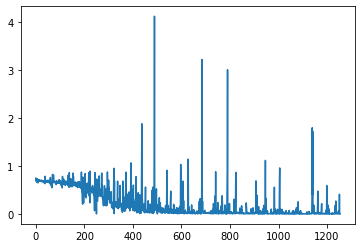

In [40]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(0, len(losses))], losses)

In [38]:
data_validation = MyDataset(200)

stacked_0 = torch.stack(data_validation.X, dim= 0)
stacked_1 = torch.stack(data_validation.y, dim= 0)
d_validation = customdataset(stacked_0, stacked_1)

validation_data_loader = DataLoader(list(zip(d_validation.x, d_validation.y)), batch_size, shuffle = True)
losses = []
total = 0
correct = 0
for epoch in range(1):
    m1.train(False)
    for i, data in enumerate(train_data_loader):
        inputs, labels = data
        inputs = inputs.squeeze(1)
        inputs = torch.unsqueeze(inputs, 1)
        outputs = m1.forward(inputs, batch_size)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    
accuracy = 100*correct/total
print("The overall validation accuracy is ", accuracy)

The overall validation accuracy is  tensor(97.5000)
